## _*LiH dissociation curve using VQE with UCCSD variational form*_

This notebook demonstrates using Qiskit Chemistry to plot graphs of the ground state energy of the Lithium Hydride (LiH) molecule over a range of inter-atomic distances using VQE and UCCSD. It is compared to the same energies as computed by the NumPyMinimumEigensolver

This notebook has been written to use the PYSCF chemistry driver.

In [1]:
import numpy as np
import pylab
import copy
from qiskit import BasicAer
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.aqua.components.optimizers import SLSQP
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.drivers import PySCFDriver
from qiskit.chemistry.core import Hamiltonian, QubitMappingType

molecule = 'H .0 .0 -{0}; Li .0 .0 {0}'
algorithms = ['VQE', 'NumPyMinimumEigensolver']

pts  = [x * 0.1  for x in range(6, 20)]
pts += [x * 0.25 for x in range(8, 16)]
pts += [4.0]
energies = np.empty([len(algorithms), len(pts)])
hf_energies = np.empty(len(pts))
distances = np.empty(len(pts))
dipoles     = np.empty([len(algorithms), len(pts)])
eval_counts = np.empty(len(pts))

print('Processing step __', end='')
for i, d in enumerate(pts):
    print('\b\b{:2d}'.format(i), end='', flush=True)
    for j in range(len(algorithms)):   
        driver = PySCFDriver(molecule.format(d/2), basis='sto3g')
        qmolecule = driver.run()
        operator =  Hamiltonian(qubit_mapping=QubitMappingType.PARITY,
                                two_qubit_reduction=True, freeze_core=True,
                                orbital_reduction=[-3, -2])
        qubit_op, aux_ops = operator.run(qmolecule)
        if algorithms[j] == 'NumPyMinimumEigensolver':
            result = NumPyMinimumEigensolver(qubit_op, aux_operators=aux_ops).run()
        else:
            optimizer = SLSQP(maxiter=1000)
            initial_state = HartreeFock(operator.molecule_info['num_orbitals'],
                                        operator.molecule_info['num_particles'],
                                        qubit_mapping=operator._qubit_mapping,
                                        two_qubit_reduction=operator._two_qubit_reduction)
            var_form = UCCSD(num_orbitals=operator.molecule_info['num_orbitals'],
                            num_particles=operator.molecule_info['num_particles'],
                            initial_state=initial_state,
                            qubit_mapping=operator._qubit_mapping,
                            two_qubit_reduction=operator._two_qubit_reduction)
            algo = VQE(qubit_op, var_form, optimizer, aux_operators=aux_ops)
            result = algo.run(QuantumInstance(BasicAer.get_backend('statevector_simulator')))
            eval_counts[i] = result.optimizer_evals
            
        result = operator.process_algorithm_result(result)
        energies[j][i] = result.energy
        hf_energies[i] = result.hartree_fock_energy
        dipoles[j][i]  = result.total_dipole_moment / 0.393430307

    distances[i] = d
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)
print('VQE num evaluations:', eval_counts)

Processing step 22 --- complete
Distances:  [0.6  0.7  0.8  0.9  1.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9
 2.   2.25 2.5  2.75 3.   3.25 3.5  3.75 4.  ]
Energies: [[-7.3133458  -7.50092206 -7.63097823 -7.7208124  -7.78224239 -7.82359927
  -7.85069837 -7.86756328 -7.87700148 -7.8810157  -7.88107203 -7.87826815
  -7.87344011 -7.86723367 -7.86015319 -7.84104235 -7.82307636 -7.80861236
  -7.79836328 -7.79175303 -7.78771683 -7.7853196  -7.78391829]
 [-7.31334583 -7.50092209 -7.63097825 -7.72081241 -7.7822424  -7.82359928
  -7.85069838 -7.86756329 -7.87700149 -7.88101572 -7.88107204 -7.87826817
  -7.87344029 -7.86723396 -7.86015321 -7.84104271 -7.82307664 -7.8086124
  -7.79836343 -7.79175325 -7.78771697 -7.78531972 -7.78391847]]
Hartree-Fock energies: [-7.29954105 -7.48594487 -7.61577016 -7.70575334 -7.76736214 -7.80874318
 -7.83561583 -7.85195386 -7.86053866 -7.86335762 -7.86186477 -7.85714496
 -7.8500187  -7.84111204 -7.83090558 -7.80193896 -7.77087367 -7.74000074
 -7.7108299  -7.6

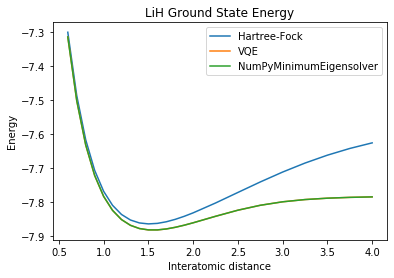

In [2]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('LiH Ground State Energy')
pylab.legend(loc='upper right');

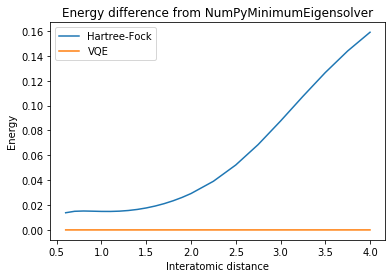

In [3]:
pylab.plot(distances, np.subtract(hf_energies, energies[1]), label='Hartree-Fock')
pylab.plot(distances, np.subtract(energies[0], energies[1]), label='VQE')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('Energy difference from NumPyMinimumEigensolver')
pylab.legend(loc='upper left');

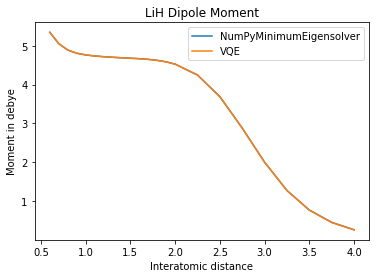

In [4]:
for j in reversed(range(len(algorithms))):
    pylab.plot(distances, dipoles[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Moment in debye')
pylab.title('LiH Dipole Moment')
pylab.legend(loc='upper right');

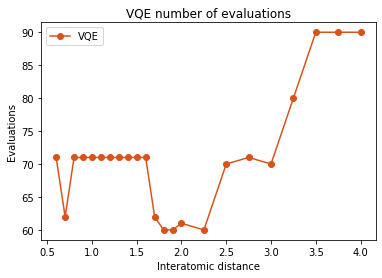

In [5]:
pylab.plot(distances, eval_counts, '-o', color=[0.8500, 0.3250, 0.0980], label='VQE')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Evaluations')
pylab.title('VQE number of evaluations')
pylab.legend(loc='upper left');